In [1]:
# Import packages 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import statsmodels.stats.multitest as smm
from pathlib import Path
from matplotlib.ticker import FixedFormatter, FixedLocator
import json

# 1 Import Data 

In [2]:
# Import DMR (for calculating the expectedDEInCat value) 
# I need the length of the DMRs 
with open(f'/home/maggy/WholeGenomeBisulphiteSequencing/GO_analysis/1_prepare_data_for_GO_analysis/dmr_unique_geneids.json', 'r') as file:
    dmr_geneids = json.load(file)


# Import GO data 
# Geneid to GO term
goterm = pd.read_csv('11_GO_enrichment_analysis/ccar2swissprotGO_long.txt', sep='\t') 
# rename columns
goterm.columns = ['gene_id', 'id']

# GO term to description
godesc = pd.read_csv('11_GO_enrichment_analysis/go_data.txt', sep='\t')
godesc.set_index('id', inplace=True)

In [3]:
go_files = sorted(Path("11_GO_enrichment_analysis/1_GO_analysis_output").glob('*_GOterms.csv'))

# total number of genes in the background dataset 
total_num_genes = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/12_gene_length_distribution/total_number_of_genes.csv', sep=',')

# create empty dict for df's
go_enriched = []


for f in go_files: 
    go_terms = pd.read_csv(f, sep=',')
    # strip emtpy space around GO terms 
    go_terms['category'] = go_terms['category'].str.strip()
    # since the term and ontology column are empty, I filled them with information from the godesc dataframe
    go_terms['term'] = godesc.loc[go_terms['category'], 'name'].to_numpy()
    go_terms['ontology'] = godesc.loc[go_terms['category'], 'namespace'].to_numpy()
    # calculate expected number in each category 
    go_terms['expectedDEInCat'] = (go_terms['numInCat']/len(total_num_genes))*len(dmr_geneids[f.stem[:4]])
    # calculate fold enrichment
    go_terms['foldEnrichment'] = (go_terms['numDEInCat']/go_terms['expectedDEInCat'])
    # calculate padj value (to correct for multiple testing) 
    go_terms['padj'] = smm.multipletests(go_terms['over_represented_pvalue'], method='bonferroni')[1]
    go_terms = go_terms.sort_values(by='over_represented_pvalue')
    go_terms = go_terms[go_terms['over_represented_pvalue'] <= 0.05]
    if 'NvsA' in f.name: 
        go_terms['comparison'] = 'Normoxia to Anoxia'
    elif 'NvsR' in f.name:
        go_terms['comparison'] = 'Normoxia to Reoxygenation'
    elif 'AvsR' in f.name:
        go_terms['comparison'] = 'Anoxia to Reoxygenation'
    
    # save to list 
    go_enriched.append(go_terms)
# merge the dataframes and add column with name of comparison
go = pd.concat(go_enriched)


In [4]:
go

,category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,expectedDEInCat,foldEnrichment,padj,comparison
1,GO:0036042,0.000632,1.000000,1,2,long-chain fatty acyl-CoA binding,MF,0.000657,1522.233333,1.0,Anoxia to Reoxygenation
2,GO:0036116,0.000632,1.000000,1,2,long-chain fatty-acyl-CoA catabolic process,BP,0.000657,1522.233333,1.0,Anoxia to Reoxygenation
3,GO:1900535,0.000632,1.000000,1,2,palmitic acid biosynthetic process,BP,0.000657,1522.233333,1.0,Anoxia to Reoxygenation
4,GO:0021987,0.000751,0.999991,2,131,cerebral cortex development,BP,0.043029,46.480407,1.0,Anoxia to Reoxygenation
5,GO:1904247,0.001027,1.000000,1,3,positive regulation of polynucleotide adenylyl...,BP,0.000985,1014.822222,1.0,Anoxia to Reoxygenation
...,...,...,...,...,...,...,...,...,...,...,...
201,GO:0050853,0.047935,0.998888,1,83,B cell receptor signaling pathway,BP,0.050890,19.650172,1.0,Normoxia to Reoxygenation
202,GO:0035987,0.048522,0.998860,1,84,endodermal cell differentiation,BP,0.051503,19.416241,1.0,Normoxia to Reoxygenation
203,GO:0031146,0.049614,0.998808,1,86,SCF-dependent proteasomal ubiquitin-dependent ...,BP,0.052730,18.964701,1.0,Normoxia to Reoxygenation
204,GO:0002062,0.049634,0.998807,1,86,chondrocyte differentiation,BP,0.052730,18.964701,1.0,Normoxia to Reoxygenation


In [8]:
# Identification of redundant GO terms 
# export GO terms and padj values as import to Revigo
for comparison, data in go.groupby('comparison'):
    regivo = data[['category', 'over_represented_pvalue']]
    regivo.to_csv(f'11_GO_enrichment_analysis/2_for_revigo_input/go_{comparison}_to_revigo.csv', index=False, sep='\t')

In [13]:
# Output from Regivo
# Since I get three files for each comparison, I will merge them into one file
base_dir = Path('11_GO_enrichment_analysis/3_revigo_output')

dfs = []

for subdir in base_dir.iterdir():
    if not subdir.is_dir():
        continue
    go_files = sorted(subdir.glob('Revigo_*_OnScreenTable.tsv'))
    for f in go_files:
        df = pd.read_csv(f, sep='\t')
        dfs.append(df)
    concatenated_df = pd.concat(dfs, ignore_index=True)
    # Define the output file path
    output_file = subdir / f"{subdir.name}_non_redundant_go_terms.csv"
    # Save the concatenated DataFrame to the output file
    concatenated_df.to_csv(output_file, index=False)

non_red_go = {'Normoxia to Anoxia': pd.read_csv('11_GO_enrichment_analysis/3_revigo_output/NvsA/NvsA_non_redundant_go_terms.csv'),
              'Normoxia to Reoxygenation': pd.read_csv('11_GO_enrichment_analysis/3_revigo_output/NvsR/NvsR_non_redundant_go_terms.csv'), 
              'Anoxia to Reoxygenation': pd.read_csv('11_GO_enrichment_analysis/3_revigo_output/AvsR/AvsR_non_redundant_go_terms.csv')}

non_red = []

# Filter the go dataframe to only include the non-redundant GO terms
for comparison, data in go.groupby('comparison'):
    non_red.append(go.loc[go['category'].isin(non_red_go[comparison]['TermID'])])
go = pd.concat(non_red)
go['log2(foldEnrichment)'] = np.log2(go['foldEnrichment'])
go.sort_values(by='log2(foldEnrichment)', ascending=False, inplace=True)


In [14]:
go

,category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,expectedDEInCat,foldEnrichment,padj,comparison,log2(foldEnrichment)
1,GO:0070268,0.000294,1.0000,1,1,cornification,BP,0.000307,3261.928571,1.0,Normoxia to Anoxia,11.671509
1,GO:0070268,0.000294,1.0000,1,1,cornification,BP,0.000307,3261.928571,1.0,Normoxia to Anoxia,11.671509
1,GO:0070268,0.000294,1.0000,1,1,cornification,BP,0.000307,3261.928571,1.0,Normoxia to Anoxia,11.671509
1,GO:0070268,0.000294,1.0000,1,1,cornification,BP,0.000307,3261.928571,1.0,Normoxia to Anoxia,11.671509
5,GO:0036116,0.000559,1.0000,1,2,long-chain fatty-acyl-CoA catabolic process,BP,0.000613,1630.964286,1.0,Normoxia to Anoxia,10.671509
...,...,...,...,...,...,...,...,...,...,...,...,...
77,GO:0070062,0.011757,0.9982,4,1524,extracellular exosome,CC,0.934417,4.280746,1.0,Normoxia to Reoxygenation,2.097862
77,GO:0070062,0.011757,0.9982,4,1524,extracellular exosome,CC,0.934417,4.280746,1.0,Normoxia to Reoxygenation,2.097862
77,GO:0070062,0.011757,0.9982,4,1524,extracellular exosome,CC,0.934417,4.280746,1.0,Normoxia to Reoxygenation,2.097862
77,GO:0070062,0.011757,0.9982,4,1524,extracellular exosome,CC,0.934417,4.280746,1.0,Normoxia to Reoxygenation,2.097862


<Axes: xlabel='ontology', ylabel='Count'>

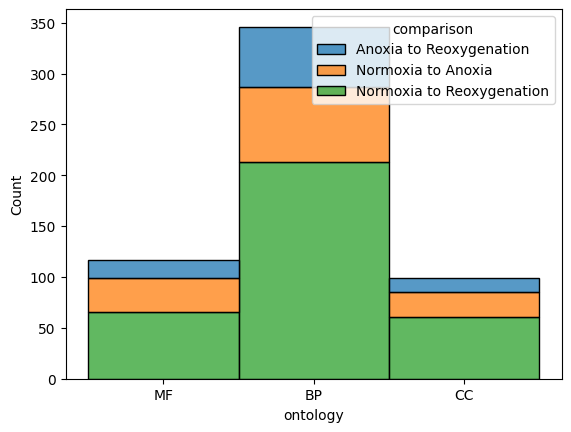

In [11]:
sns.histplot(data=go, x='ontology', hue='comparison', bins=10, multiple='stack')

In [31]:
# go through and only keep the top ten for each ontology 
go_for_plot=[]

for (ontology,comparison), data in go.groupby(['ontology', 'comparison']):
    temp = data.sort_values(by=['log2(foldEnrichment)', 'over_represented_pvalue'], ascending=[False, True]).iloc[:15]
    go_for_plot.append(temp)
go_plot = pd.concat(go_for_plot)

# 2 PLOT 

/home/maggy/anaconda3/envs/methylscore/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


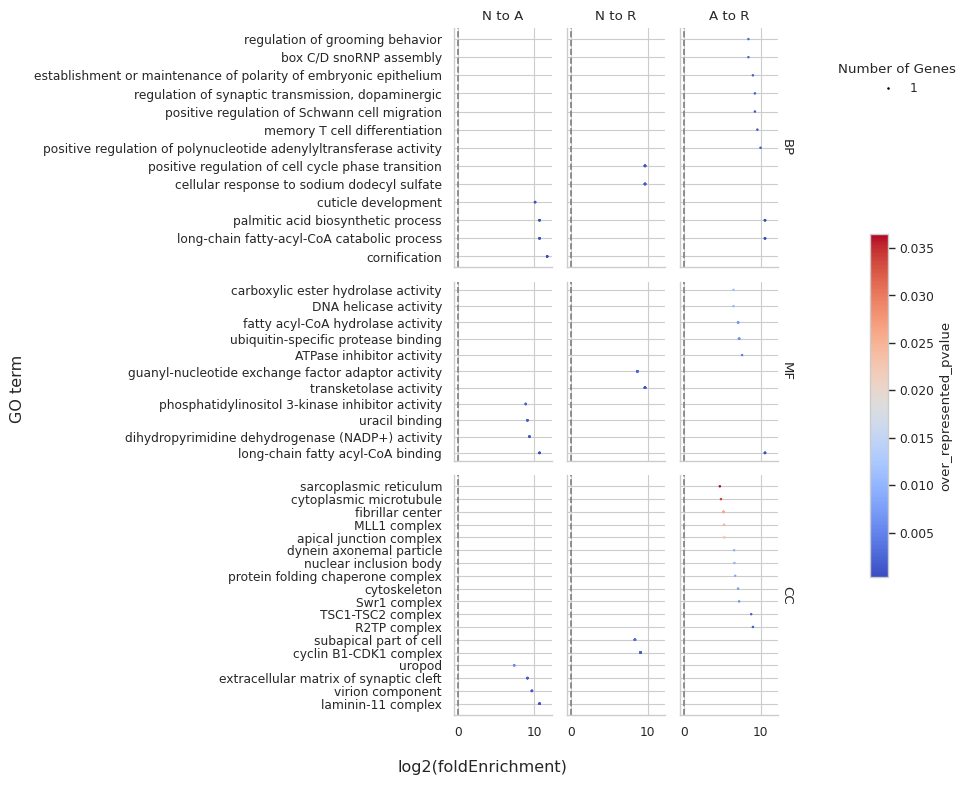

In [32]:
# define a function to acces the df in arrays 
def custum_scatterplot(data, norm, cmap, **kwargs):
    scatter = plt.scatter(x=data['log2(foldEnrichment)'], y=data['term'], c=data['over_represented_pvalue'], s=data["numDEInCat"], norm=norm, cmap=cmap)
    h, l = scatter.legend_elements(prop='sizes', num=FixedLocator([int(go_plot['numDEInCat'].min()),20, 50,int(go_plot['numDEInCat'].max())], nbins=5))
    handles.extend(h)
    labels.extend(l)
# needed for legend number of Genes 
handles, labels = [], []

# create color bar
norm = plt.Normalize(go_plot['over_represented_pvalue'].min(), go_plot['over_represented_pvalue'].max())
cmap = sns.color_palette(palette='coolwarm', as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# create a Facetgrid 3x3
sns.set_theme(style="whitegrid", palette="coolwarm", context='paper')
g = sns.FacetGrid(go_plot, col='comparison', row ='ontology', sharey='row', sharex = True, gridspec_kws={'height_ratios':[4,3,4]}, 
                  col_order=['Normoxia to Anoxia', 'Normoxia to Reoxygenation', 'Anoxia to Reoxygenation'], row_order= ['BP', 'MF', 'CC' ], margin_titles=True)

# set size for fig 
g.figure.set_figwidth(25/2.54)
g.figure.set_figheight(20/2.54)
g.map_dataframe(custum_scatterplot, norm=norm, cmap=cmap)

# set title 
g.set_titles(template= '', col_template='', row_template='{row_name}')   
g.figure.supxlabel('log2(foldEnrichment)')
g.figure. supylabel('GO term')
g.axes_dict[('BP', 'Anoxia to Reoxygenation')].set_title('A to R')
g.axes_dict[('BP', 'Normoxia to Reoxygenation')].set_title('N to R')
g.axes_dict[('BP', 'Normoxia to Anoxia')].set_title('N to A')
g.refline(x=0)


# legend NUmber of Genes 
han = pd.Series(handles, index=labels)
han = han.loc[~han.index.duplicated(keep='first')]
han.index = han.index.str.replace('$\mathdefault{', '')
han.index = han.index.str.replace('}$', '')
han.index = han.index.astype(int)
han = han.sort_index(ascending=True)

legend = g.axes[0,2].legend(han.values, han.index, loc="upper left", title="Number of Genes", bbox_to_anchor=(1.5, 0.9), frameon=False)

# add color bar 
plt.colorbar(sm, label='over_represented_pvalue', use_gridspec=True, ax=g.axes, location='right', shrink=0.5, pad=-0.1, anchor=(0,0.4))

g.tight_layout()

In [ ]:
dmr_test = go.loc[go['over_represented_pvalue']<= 0.05]

In [ ]:
dmr_test

In [ ]:
dmr_test_na = dmr_test.loc[dmr_test['comparison'] == 'Normoxia to Anoxia']	
dmr_test_nr = dmr_test.loc[dmr_test['comparison'] == 'Normoxia to Reoxygenation']
dmr_test_ar = dmr_test.loc[dmr_test['comparison'] == 'Anoxia to Reoxygenation']

# select only two columns
dmr_test_na = dmr_test_na[['category', 'over_represented_pvalue']]
dmr_test_nr = dmr_test_nr[['category', 'over_represented_pvalue']]
dmr_test_ar = dmr_test_ar[['category', 'over_represented_pvalue']]

In [ ]:
dmr_test_na.to_csv('11_GO_enrichment_analysis/2_GO_NvsA.csv', index=False, sep='\t')
dmr_test_nr.to_csv('11_GO_enrichment_analysis/2_GO_NvsR.csv', index=False, sep='\t')
dmr_test_ar.to_csv('11_GO_enrichment_analysis/2_GO_AvsR.csv', index=False, sep='\t')